In [ ]:
#from pydantic import BaseModel, Extra

In [ ]:
from graph_fmt import *

# Connect to Aerospike Graph
g = traversal().withRemote(DriverRemoteConnection('ws://0.0.0.0:8182/gremlin','g'))
g.V().drop().iterate()
g.with_("evaluationTimeout", 86400000)\
 .call("bulk-load")\
    .with_("aerospike.graphloader.vertices", "data/ad_tech/vertices")\
    .with_("aerospike.graphloader.edges", "data/ad_tech/edges")\
    .next()

'Success'

<img src="../img/adtech.png" alt="Drawing" width="1900" height="100"/>
          
# Aeropspike Graph for Advertisement Technology

If you are interested in advertising technology and modern graph solutions this is the blog for you.  Adtech, short for advertising technology, refers to the array of tools, technologies, and platforms utilized in the advertising industry to automate and optimize the process of buying, selling and delivering adverisements to target audiences. It encompasses various digital marketing strategies, data analysis, ad placement, audience targeting, and campain optimization techniques.

Aerospike is popular with adtech companies for several reasons:

- Real-time analytics: Aerospike is known for its ability to handle large amounts of data and process it in real-time. Adtech companies rely on real-time analytics to target and deliver personalized ads to users based on their browsing behavior and preferences.
- High performance and low latency: Aerospike's database architecture is optimized for high performance and low latency. Adtech companies require fast data retrieval and write operations to ensure smooth ad serving and real-time bidding process
- Scalability: Adtech companies deal with massive amounts of data that need to be processed and analyzed quickly. Aerospike's database is higly scalable, allowing adtech companies to handle increasing data volumes without compromising performance.
- Reliability and availability: Adtech companies heavily rely on data availability for uninterrupted ad serving. Aerospike offers high availability and fault tolerance with its NoSQL database, ensuring that the adtech systems remain operational under heavy load and even in the event of failures.
- Affordability: Aerospike is designed to efficiently utilize hardware resources, leading to lower infrastructure cost for adtech companies. This makes it a cost-effeticve choice for companies looking to manage and analyze large volumes of data without substancial investment.

Aerospike has added a new model and features to provide a distributed graph database capability known as Aerospike Graph. It is specifically designed to handle large-scale graph and graph query workloads with low latency and high throughput.

Aerospike Graph organizes data as vertices and edges, where vertices represent entities or nodes, and edges represent relationships between the entities. It support a variety of graph operations, including graph traversal, pattern matching, shortes path discovery, and graph analytics, enabiling users to perform complex analysis and derive insight from the interconnected relationships in their data.

Aerospike Graph leverages the distributed architecture of the Aerospike database, allowing it to scale horizontally across multiple nodes and handle massive data sets. It provides fast and efficient graph traversals by utilizing indexes and in-memory data structures. Additionally, it supports real-times updates and mantains consistency across distributed environments.

Overall, Aerospike Graph offers a scalable, high-performance solution for managing and querying graph data, making it suitable for various applications such as social networks, recommendations systems, fraud detection, network analysis and adtech, among others.

Without further ado, lets dive into the details.

## The AdTech Graph Schema

In the ad-tech industry, a typical graph schema consists of various entities and their relationships. In this blog a simplified schema will be used.  

### Vertices

Vertices are used in graph databases, and represent entities such as accounts, businesses, people, or any other item being tracked. Properties are attributes of the entities. In a relational database, vertices are the rough equivalent of a row, record, or relation. Properties are the rough equivalent to attributes or columns.

| Vertices | Properties|
|---------:|:----------|
|ad_unit| ad_unit_id, measurable_impressions, total_impressions, viewable_impressions|
|geos| geo_id|
|monetization_channels|monetization_channel_id|
|os|os_id|
|ad_types|ad_type_id|
|advertisers|advertiser_id|
|dates|average_revenue, date_id, observations, revenue_max, revenue_min, total_revenue|
|orders|ord_average_revenue, ord_revenue_max, ord_revenue_min, ord_total_revenue, order_count, order_id|
|sites|site_id|
|line_items|line_item_type_id|
|device_categories|device_category_id
|integration_types|integration_type_id|

### Edges

Relationship edges connect the entities and represent the relationships between them. For example:

| Edges | Properties|
|---------:|:----------|
|in_geo|set()|
|placed_by|set()|
|from_device|set()|
|from_site|set()|
|channel_used|set()|
|has_line_item_type|set()|
|has_unit|set()|
|order_placed|set()|
|has_os|set()|
|is_of_type|set()|
|has_integration|set()|

This is just a general overview, and the actual graph schema used in the ad-tech industry may vary based on specific requirements and platforms. A graphical representation of the schema is depicted below. In Aerospike Graph you can easily generate the schema using the following Gremlin query:

    g.V("~graph_summary").valueMap().toList()

In [ ]:
pp = PrettyPrinter(indent=4, width=80)
graph_stats = pd.DataFrame(g.V("~graph_summary").valueMap().toList())   # GREMLIN QUERY
display(dgraph_sch(graph_stats, g))

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'any', 'style': {'content': '…

You can further process the data stored in the summary dataframe to produce a histogram of the vertices and edges.

### Calculating revenue by device type and site

Calculating revenue by device type and site in the adtech industry is important for several reasons:

- Performance analysis: By analyzing revenue data by device type and site, adtech companies can understand which devices (e.g., desktop, mobile, tablet) and websites are generating the most revenue. This allows them to optimize their advertising strategies accordingly. For example, if mobile devices are generating the highest revenue, businesses can focus on improving the user experience and ad targeting for mobile users.

- Budget allocation: Knowing the revenue generated by different device types and sites helps adtech companies allocate their advertising budgets effectively. If certain websites or device types are consistently performing better than others, businesses can allocate a larger share of their budget towards those channels to maximize their return on investment.

- Ad pricing and inventory management: Revenue data by device type and site enhances the ability to set appropriate ad prices and manage available inventory. Websites that consistently generate high revenue can be considered premium inventory, and advertisers may be willing to pay a higher price to display their ads on those sites. On the other hand, if specific device types or sites are underperforming, adjusting ad prices or reallocating inventory can help optimize overall revenue.

- Business partnerships: Revenue data by device type and site is valuable information for negotiating partnerships with advertisers, publishers, or agencies. Adtech companies can use this data to demonstrate their reach and revenue potential on different devices and websites, making them more attractive to potential partners.

- Strategy refinement: Detailed revenue analysis allows adtech companies to identify trends and patterns in user behavior. For example, if revenue from mobile devices is increasing rapidly, it may indicate the need to prioritize mobile advertising strategies and optimize the user experience for smaller screens. Such insights enable businesses to refine their advertising strategies and stay competitive in the evolving adtech landscape.

Using the Gremlin queries below you can retrive the data from Aerospike Graph. The first query creates a list of all the different device categories vertices and orders them in ascending order.  

    vertices=g.V().hasLabel('device_categories').order().toList()

The second query process the list of vertex ids (i.e., vertices) and stores the results in 's' traverses using the **as** step modulator. Then it traverses the **from_device** edge, that is the IN edge of the device_categories vertex and stores the vertex set in 't'. Finally, it generates a list of all the relationships between orders and device_categories.

    results=g.V(vertices).as_('s').in_().as_('t').select('s', 't').toList()


### Vertices and Edges Distribution

#### Total Number of Vertices: 516; Total Number of Edges: 9301

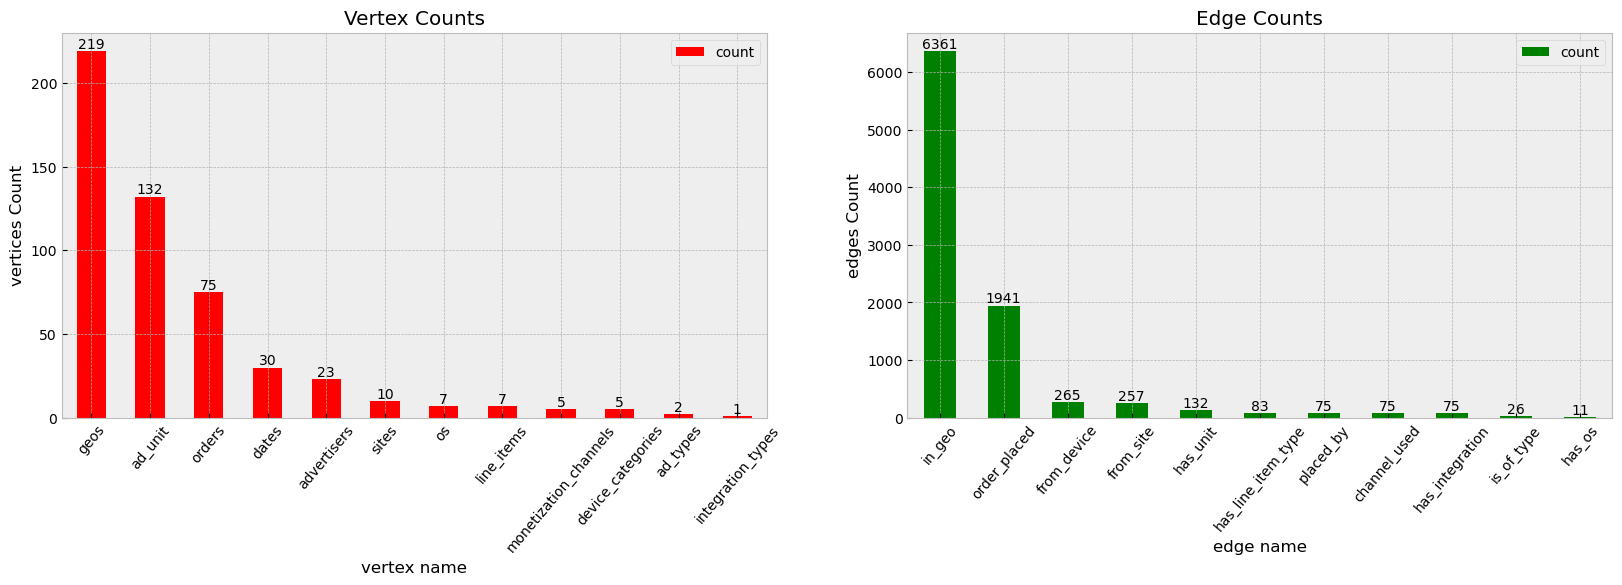

In [ ]:
display_markdown(f'''### Vertices and Edges Distribution''', raw=True)
display_markdown(f'''#### Total Number of Vertices: {graph_stats.vertex_count.values.tolist()[0][0]}; Total Number of Edges: {graph_stats.edge_count.values.tolist()[0][0]}''', raw=True)
display_dist(graph_stats)

Text(0.5, 0.98, 'Total Revenue based on device type')

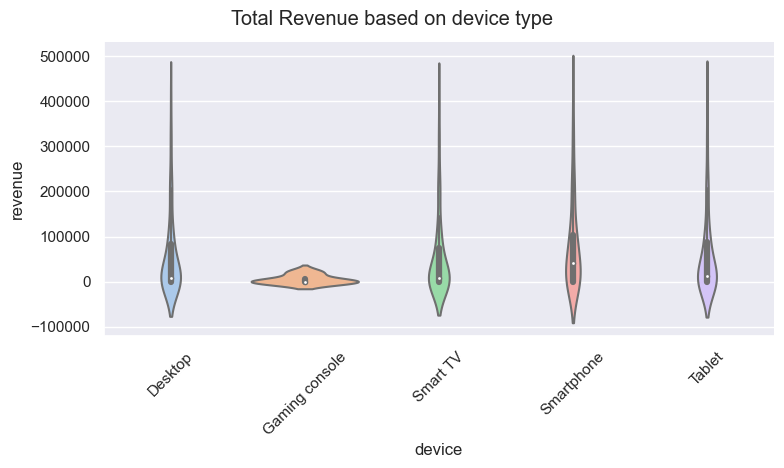

In [ ]:
sns.set(style="darkgrid")
df_dev_rev = pd.DataFrame(columns=['device', 'revenue'])
vertices=g.V().hasLabel('device_categories').order().toList()
results=g.V(vertices).as_('s').in_().as_('t').select('s', 't').toList()
for index in range(len(results)):
    x = g.V(results[index]['s']).values().toList()
    y = g.V(results[index]['t']).values('order_id', 'ord_total_revenue').toList()
    df_dev_rev.loc[index] = [x[0],y[0]]
ax = sns.catplot(x="device", y="revenue", data=df_dev_rev, palette = 'pastel', height = 4, aspect = 2, kind="violin")
ax.tick_params(axis='x', rotation=45)
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle('Total Revenue based on device type')

A simple variation of the query above can be used to get the revenue by different sites.  In his case, the starting point is the **sites** vertex and then traverse the **from_site** edge.

    vertices=g.V().hasLabel('sites').order().toList()
    results=g.V(vertices).as_('s').in_().as_('t').select('s', 't').toList()

Text(0.5, 0.98, 'Total revenue by different sites')

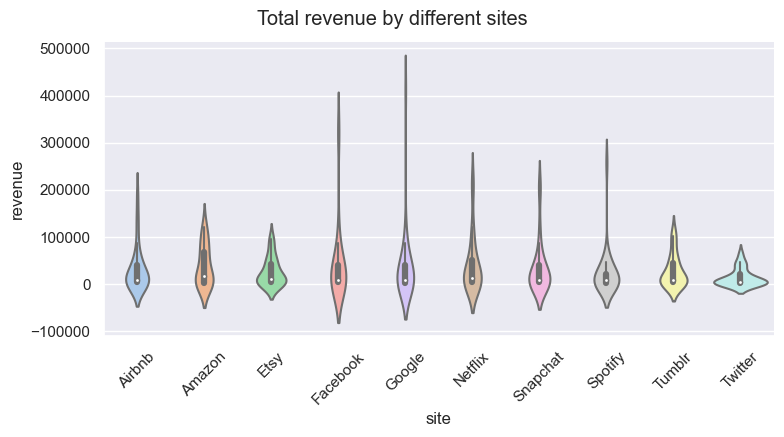

In [ ]:
df_site_rev = pd.DataFrame(columns=['site', 'revenue'])
vertices=g.V().hasLabel('sites').order().toList()
results=g.V(vertices).as_('s').in_().as_('t').select('s', 't').toList()
for index in range(len(results)):
    x = g.V(results[index]['s']).values().toList()
    y = g.V(results[index]['t']).values('order_id', 'ord_total_revenue').toList()
    df_site_rev.loc[index] = [x[0],y[0]]
ax = sns.catplot(x="site", y="revenue", data=df_site_rev, palette = 'pastel', height = 4, aspect = 2, kind="violin")
ax.fig.subplots_adjust(top=0.9)
ax.tick_params(axis='x', rotation=45)
ax.fig.suptitle('Total revenue by different sites')

### Analyze impressions by site and number of orders by Geo

Viewable impressions and measurable impressions are two common metrics used in ad tech to measure the effectiveness and reach of an ad campaign.

- Viewable impressions: Viewable impressions refer to the number of times an ad was actually seen by a user. Ads are considered viewable when at least 50% of their pixels are visible on the screen for at least one second (as defined by the Media Rating Council). This metric helps advertisers understand the visibility and potential impact of their ads. By focusing on viewable impressions, advertisers can ensure that their ads are being seen by their intended audience.

- Measurable impressions: Measurable impressions are the total number of ad impressions that can be tracked and measured by an ad technology platform or third-party ad tracking company. These impressions are typically counted when an ad is requested by a user's device or browser. Measurable impressions help advertisers track the reach and frequency of their ad campaigns and provide data to optimize and assess the success of their campaigns.

Analyzing impressions is essential for adtech companies for several reasons:

- Performance assessment: Analyzing impressions allows adtech companies to evaluate the effectiveness of their ad campaigns and measure the performance of their advertisements. They can determine the number of impressions served, the reach and frequency of the ads, and track metrics such as click-through rates (CTR) or conversion rates. This analysis helps them understand how well their ads are capturing the attention of their target audience and driving desired actions.

- Optimization and targeting: By analyzing impressions, adtech companies can identify patterns and insights about their audience's behavior, demographics, interests, and preferences. This information allows them to optimize their ad placements and targeting strategies, ensuring that ads are shown to the right people, at the right time, and in the right context. It helps them refine their targeting parameters, adjust bid strategies, and improve overall campaign performance.

- Cost efficiency: Analyzing impressions helps adtech companies to optimize their ad spend and maximize their return on investment (ROI). They can identify which ad placements or channels are generating the most impressions and conversions at a lower cost, enabling them to allocate their budget more efficiently. By understanding which impressions are highly valuable and drive the desired outcomes, they can focus on channels and strategies that deliver the best results.

- Audience insights: Analyzing impressions provides adtech companies with valuable data and insights about their target audience. They can learn about their audience's online behavior, preferences, and trends, helping them to tailor their marketing messages and creative content to resonate with their target audience. It enables them to refine their audience segmentation and create personalized ad experiences that are more likely to engage and convert users.

- Competitive analysis: Analyzing impressions also allows adtech companies to monitor their competitors' activities and trends. By understanding their competitors' ad placements, strategies, and performance metrics, they can identify opportunities for differentiation and improvement. It helps them stay ahead of the competition and adjust their advertising strategies to gain a competitive edge in the market.

Overall, analyzing impressions provides adtech companies with valuable insights and data that drive effective targeting, optimize ad campaigns, and improve ROI. It helps them make data-driven decisions and refine their strategies to achieve better results in the constantly evolving advertising landscape.

In [ ]:
df_impressions = pd.DataFrame(columns=['site', 'ad_unit', 'measurable_impressions', 'total_impressions', 'viewable_impressions'])
vertices=g.V().hasLabel('sites').order().toList()
results=g.V(vertices).as_('s').out().as_('t').select('s', 't').toList()
for index in range(len(results)):
    x = g.V(results[index]['s']).values().toList()
    y = g.V(results[index]['t']).values('ad_unit_id', 'measurable_impressions', 'total_impressions', 'viewable_impressions').toList()
    df_impressions.loc[index] = [x[0],y[0],y[1],y[2],y[3]]

### Analyzing the geos.

Analyzing the geos (short for geographical locations) is important in adtech companies for several reasons:

- Targeted advertising: Analyzing the performance of different geos helps determine which regions or countries are more responsive to ad campaigns. This information enables adtech companies to allocate their resources effectively and target specific markets based on their potential return on investment.

- Cost optimization: By assessing the performance of geos, adtech companies can identify regions where the cost of acquiring users or customers is relatively lower. This allows them to focus their advertising efforts in those areas, optimizing their spending and maximizing their return.

- User behavior and preferences: Analyzing geos helps uncover insights into user behavior and preferences specific to different regions. Adtech companies can understand how users from different geos interact with ads, what products/services they are more interested in, and how they engage with different ad formats. This knowledge can then be used to tailor ad campaigns and optimize user experience accordingly.

- Expansion opportunities: Analyzing geos can also reveal new market opportunities for adtech companies. Identifying regions with high growth potential or relatively untapped markets helps them prioritize expansion efforts and focus on capturing new customers in those areas.

- Competitor analysis: Assessing the performance of different geos can also help adtech companies understand their competition on a global or regional scale. By comparing their performance in different markets to that of their competitors, they can recognize areas where they need to improve or differentiate their offerings to gain a competitive advantage.

In summary, analyzing geos in adtech companies provides insights that enable effective targeting, cost optimization, understanding user behavior and preferences, identifying expansion opportunities, and assessing competition. All of these factors contribute to the overall success and profitability of ad campaigns and the company as a whole. The following query produces a report of the worst 10 geos based on the actual sales orders:

    g.with_("evaluationTimeout", 86400000)
     .V().hasLabel('geos')                         
     .project("geo","bottom")                       
     .by().by(inE()
     .count())
     .order()
     .by(asc)
     .limit(10)
     .toList())
    
    
    
    

In [ ]:
df_bottom_sales = pd.DataFrame.from_dict(g.with_("evaluationTimeout", 86400000).V().hasLabel('geos').project("geo","bottom").by().by(inE().count()).order().by(asc).limit(10).toList())
df_bottom_sales = df_bottom_sales.rename(columns={"bottom": "orders"})
df_bottom_sales['geo'] = df_bottom_sales['geo'].astype(str)
pat = r'v\[(.*)\]'
df_bottom_sales['geo'] = df_bottom_sales['geo'].str.extract(pat)
df_bottom_sales['orders'] = df_bottom_sales['orders'].astype('Int64')

### Create a visualization using Seaborn and Matplotlib

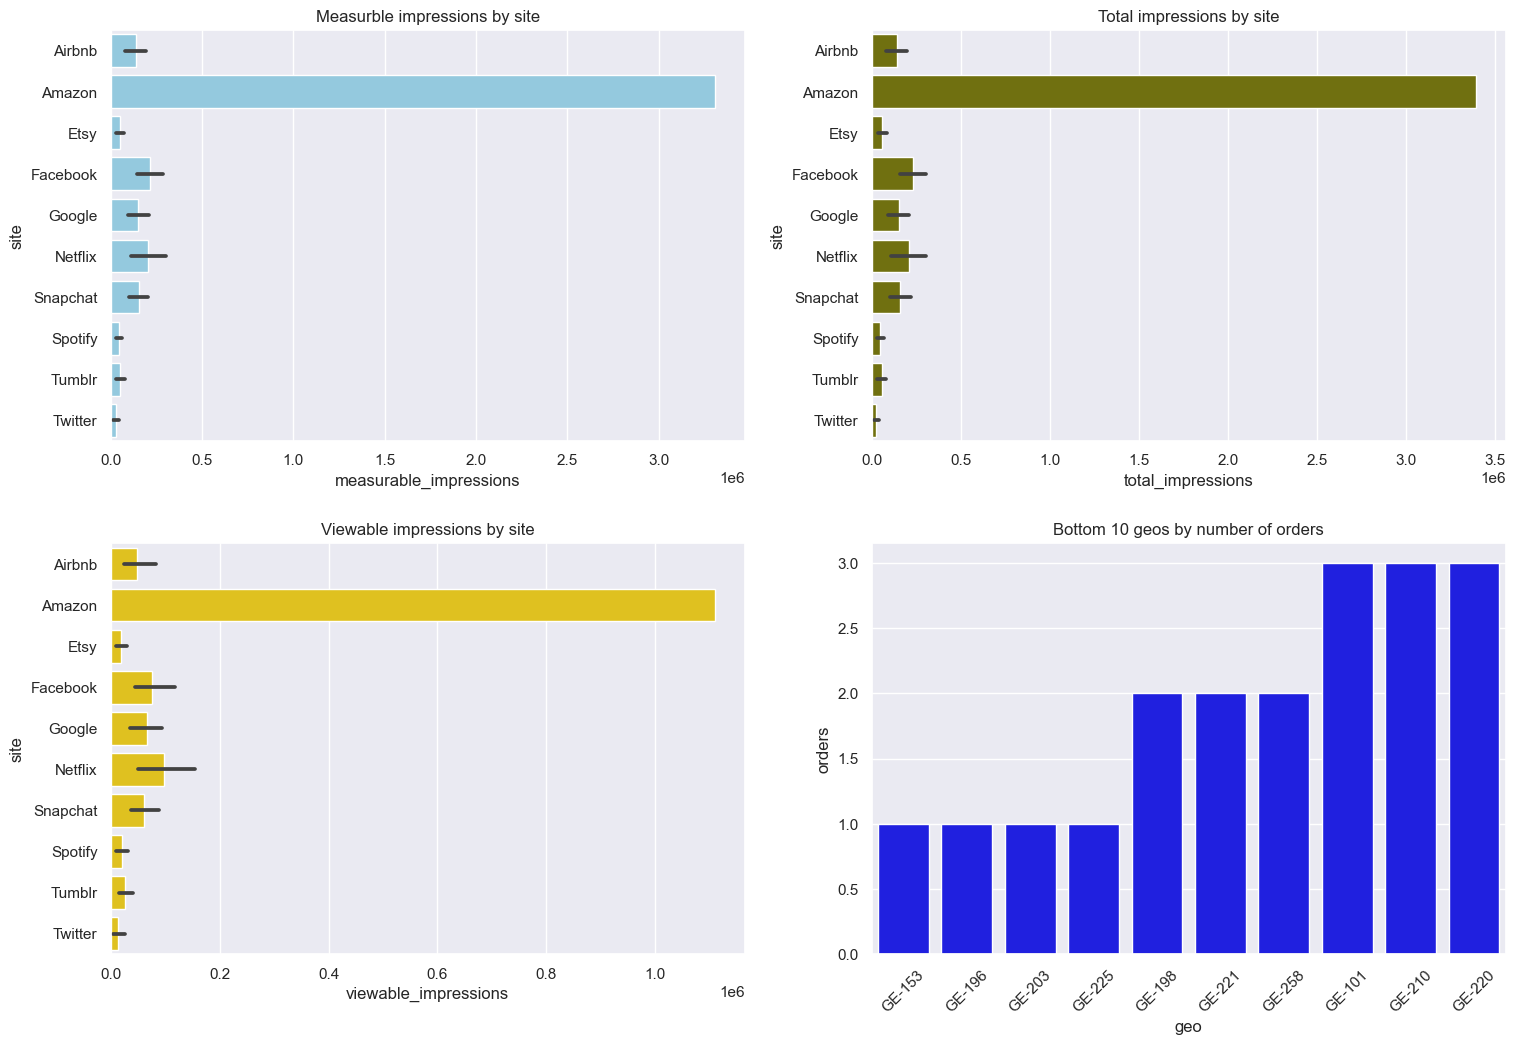

In [ ]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
plt.tick_params(axis='x', rotation=45)
plt.subplots_adjust(hspace=.25)
sns.barplot(data=df_impressions, y="site", x="measurable_impressions", color="skyblue", ax=axs[0, 0]).set(title='Measurble impressions by site')
sns.barplot(data=df_impressions, y="site", x="total_impressions", color="olive", ax=axs[0, 1]).set(title='Total impressions by site')
sns.barplot(data=df_impressions, y="site", x="viewable_impressions", color="gold", ax=axs[1, 0]).set(title='Viewable impressions by site')
sns.barplot(data=df_bottom_sales, x="geo", y="orders", color="blue", ax=axs[1, 1]).set(title='Bottom 10 geos by number of orders')
plt.show()

## In short

<img align="right" width="300" height="100" src="../img/AerospikeArch.png" alt="Drawing"/>

By using the power of Aerospike Graph and the Aerospike database, Adtech companies can leverage the ease of use of Gremlin and graph to analyze ther operational data derive insights. In summary Aerospike provides the following advantages:

### Real time

Applications require high throughput to handle massive graph workloads with 100s or thousands Queries Per Second with low latency for multi-hop queries.

A Massively scalable graph database like Aerospike - Independently scale compute and storage to meet throughput requirements with large data sets.
Adtech companies can benefit from using Aerospike Graph and Aerospike Database with Gremlin for the following reasons:

High performance: Aerospike Database and Graph are designed to handle large-scale data processing and complex graph queries efficiently. They provide high-performance and low-latency access to data, which is crucial in the fast-paced adtech industry where real-time decision making is essential.

Scalability: Adtech companies deal with large volumes of data. Aerospike Database and Graph are horizontally scalable, allowing companies to handle increasing data loads without sacrificing performance. This scalability ensures that adtech companies can adapt to growing data requirements without experiencing bottlenecks.

Real-time data processing: Aerospike Database and Graph can process and analyze data in real-time, enabling adtech companies to make timely decisions based on up-to-date information. This is essential in the adtech industry, where ad campaigns need to be optimized continuously to achieve better outcomes.

Highly available and fault-tolerant: Aerospike Database and Graph are designed to have built-in high availability and fault-tolerance features. This ensures that adtech companies can maintain continuous operations, even in the face of hardware failures or network disruptions, contributing to improved reliability and minimal downtime.

### Native support for Gremlin

Complex graph queries: Aerospike Graph incorporates the Gremlin query language, which is widely used in graph databases and provides a flexible and expressive way to query and analyze graph data. Adtech companies can leverage this capability to gain deeper insights into customer behavior, target audiences effectively, and optimize ad placements based on complex relationships within the graph.

Adaptable data model: Aerospike Graph combines the best features of key-value stores and graph databases, allowing adtech companies to manage both graph-based relationships and key-value data efficiently. This flexibility in data modeling ensures that adtech companies can store and analyze diverse data types in a single database, simplifying the infrastructure and reducing operational complexity.

Overall, using Aerospike Graph and Aerospike Database with Gremlin enables adtech companies to process large volumes of data, perform complex graph queries, and achieve high availability and scalability, enhancing their ability to make data-driven decisions and optimize advertising campaigns effectively.

### Efficient bulk loading

Enables you to load large volumes of data in a timely manner.

### Operational efficiency

A single database for multiple data models simplifies administration and lowers your TCO.

Overall, Aerospike Graph offers a scalable, high-performance solution for managing and querying graph data, making it suitable for various adtech applications.